In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_files,load_svmlight_file
from sklearn.metrics.pairwise import euclidean_distances
from copy import deepcopy
from random import randint
import scipy as sp
from scipy import sparse

In [84]:
#load the data in SVMLight format
iris_data = load_svmlight_file("Data/iris.scale")
#create a response decoding dictionary
response_dict = {1:'Iris Setosa',2:'Iris Versicolour',3:'Iris Virginica'}

In [234]:
def eucDist(x,y):
    '''
    measure euclidean distance
    '''
    diff = x-y
    #print(type(diff))
    return np.sqrt(diff.multiply(diff).sum(1))

def clusterDist(data,centroid):
    '''
    Distance of a point from cluster
    '''
    cluster = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        cluster[i]=eucDist(data[i],centroid)
    return cluster

def findCentroid(data,k):
    '''
    Obtain centroid for k values
    Start with random, then take the point distance from all previous centroids
    '''
    centroids = np.zeros((k,data.shape[1]))
    centroids[0] = data[[randint(0,data.shape[0]-1)]].toarray()
    dist = np.zeros((data.shape[0],k))
    dist[:,0]  = clusterDist(data,sparse.csr_matrix(centroids[0]))
    for cls in range(1,k):
        centroids[cls] = data[np.argmax(dist.sum(axis=1))].toarray()
        dist[:,cls]  = (clusterDist(data,sparse.csr_matrix(centroids[cls])))
    #print(centroids)
    return centroids

def KMeanImproved(data,response,k):
    '''
    Perform the KMean 
    '''
    cluster_point_new = {}
    cluster_point_old = {}
    first_pass = True
    n= data.shape[0] #number of samples
    centroid_old = np.zeros((k,data.shape[1]))# to store old centers
    centroid_new = data[list(randint(0,data.shape[0]) for i in range(k))]  #create_centroids(data,k,centroid_new)
    clusters = np.zeros(n)
    dist = np.zeros((n,k)) #store the distance
    while cluster_point_old != cluster_point_new or first_pass:
        first_pass = False
        for i in range(k):
            dist[:,i] = clusterDist(data,centroid_new[i]) #calculate the distance from centroid to all point
        clusters = np.array(np.argmin(dist, axis = 1))
        cluster_point_old = deepcopy(cluster_point_new)
        for i in range(k):
            cluster_point_new[i] = list(np.argwhere(clusters == i).flatten()) #assign cluster points
            centroid_new[i] = np.array(data[cluster_point_new[i]].mean(axis=0)) #create centroids
    cluster_label = build_cluster_label(cluster_point_new,response) #create labels for centroids
    return centroid_new,cluster_label,cluster_point_new

def KMeanOptimized(data,response,k):
    '''
    Perform the KMean 
    '''
    cluster_point_new = {}
    cluster_point_old = {}
    first_pass = True
    n= data.shape[0] #number of samples

    centroid_new = data[list(randint(0,data.shape[0]) for i in range(k))]  #create_centroids(data,k,centroid_new)
    clusters = np.zeros(n)
    dist = np.zeros((n,k)) #store the distance
    while cluster_point_old != cluster_point_new or first_pass:
        first_pass = False
        for i in range(k):
            dist[:,i] = clusterDist(data,centroid_new[i]) #calculate the distance from centroid to all point
        clusters = np.array(np.argmin(dist, axis = 1))
        cluster_point_old = deepcopy(cluster_point_new)
        for i in range(k):
            cluster_point_new[i] = list(np.argwhere(clusters == i).flatten()) #assign cluster points
            centroid_new[i] = np.array(data[cluster_point_new[i]].mean(axis=0)) #create centroids
    cluster_label = build_cluster_label(cluster_point_new,response) #create labels for centroids
    return centroid_new,cluster_label,cluster_point_new

def build_cluster_label(cluster_point_new,response):
    cluster_label = {}
    for index,value in cluster_point_new.items():
        #print(type(value))
        cluster_label[index] = round(np.sum(response[value])/len(response[value]))
    return cluster_label
    
def predict(data,centroids,clusters,encoding_dict):
    '''
    Perform prediction 
    '''
    pred_label = []
    for row in data:
        pred_label.append(clusters[np.argmin([clusterDist(row,sparse.csr_matrix(center)) for center in centroids])])
    return pred_label

def sse(data,clusters,centroid_new,k):
    '''
    Evaluate the intra cluster distance
    '''
    total_error = 0
    for i in range(k):
        total_error+=np.sum(clusterDist(data[clusters[i]],centroid_new[i]))
    return total_error

## Iris Dataset

### We use elbow method, in which the elbow of the curve between the distortion and cluster value is taken as optimal k value

In [142]:
#choose the best k value using elbow curve
import time
scores = {}
times = {}
#running for 5 different K values
for k in range(5):
    start = time.time()
    centroids,cluster_label,clusters = KMeanImproved(iris_data[0],iris_data[1],k+1)
    #print(clusters)
    end = time.time()
    scores[k+1] = (sse(iris_data[0],clusters,centroids,k+1))
    times[k+1]= (end - start)
    

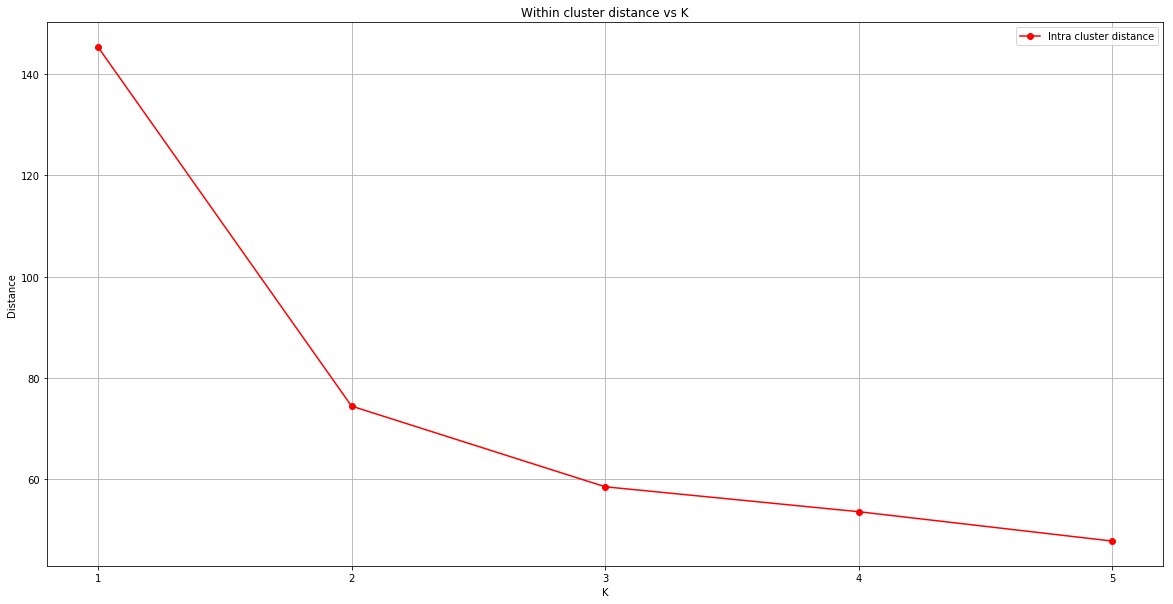

In [166]:
plt.figure(figsize=(20, 10))
plt.plot(scores.keys(),scores.values(),'-ro')
plt.grid()
plt.title("Within cluster distance vs K")
plt.xticks(range(1,6))
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend(["Intra cluster distance"])
plt.show()

### We can see the distance decrease and being flattened at around k = 3, hence we can use k as 3

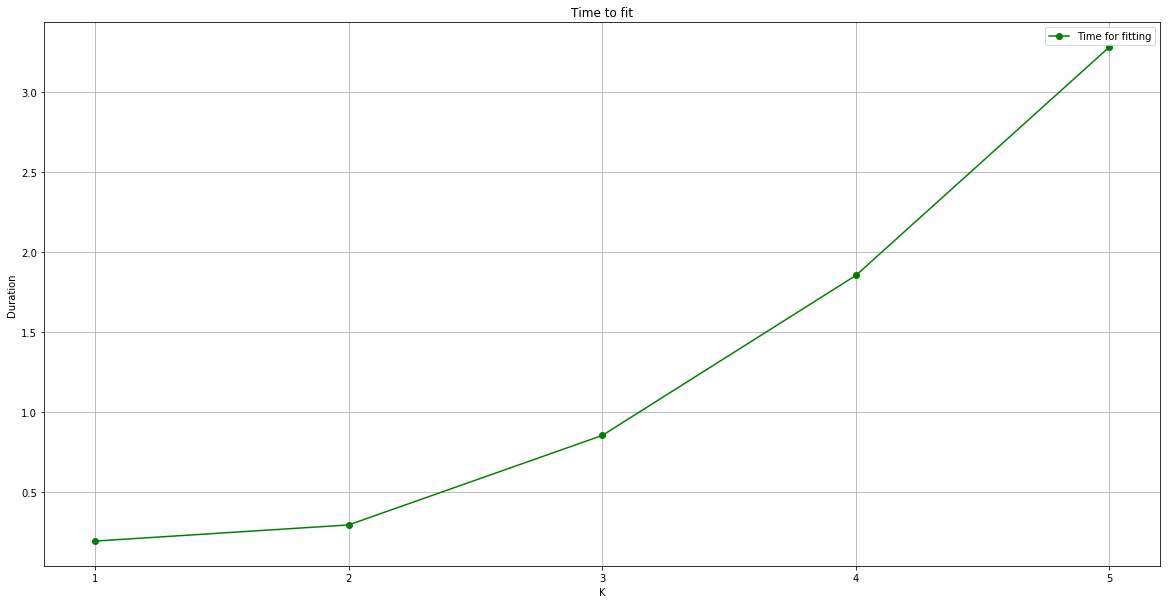

In [165]:
plt.figure(figsize=(20, 10))
plt.plot(times.keys(),times.values(),'-go')
plt.grid()
plt.title("Time to fit")
plt.xticks(range(1,6))
plt.xlabel("K")
plt.ylabel("Duration")
plt.legend(["Time for fitting"])
plt.show()

### Performing a fitting and prediction step on KMeans and it's total time

In [235]:
%time centroids,cluster_label,clusters = KMeanImproved(iris_data[0],iris_data[1],3)
%time predicted_class  = predict(iris_data[0],centroids,cluster_label,response_dict)
%time sse(iris_data[0],clusters,centroids,3)

Wall time: 2.3 s
Wall time: 189 ms
Wall time: 48.9 ms


58.55770236541426

#### The centroids  

In [243]:
print(centroids.toarray())

[[-0.60777778  0.18166667 -0.84271174 -0.88000014]
 [-0.11748638 -0.38524591  0.15143093  0.09836071]
 [ 0.41452981 -0.09829064  0.59408938  0.64957267]]


In [246]:
print(predicted_class)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0]


## Cluster news article

### Due to scalability we will create our lightSVM file using the vectorized text corpus and export it to more scalable platforms

In [239]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import dump_svmlight_file


def load_data(data):
    '''
    loads the data from subdirectory and creates response variable based on the folder name
    '''
    x = []
    y = []
    for category in os.listdir(data):
        for fileName in os.listdir(data+"/"+str(category)):
            with open(data+"/"+str(category)+"/"+str(fileName), 'r') as file:
                x.append(file.read())
                y.append(category)
    return x, y

def fetchStopWords():
    '''
    load the stop words from text file
    '''
    f = open("stopwords.txt", "r")
    stopwords = f.read()
    return stopwords.split('\n')

def vectorize(train_data,test_data):
    '''
    Create a TF-IDF and transform both test and train
    In real time this will be included as a pipeline component
    '''
    vectorizer = TfidfVectorizer(stop_words = fetchStopWords(),
                                 min_df=10, 
                                 lowercase = True, 
                                 ngram_range=(1, 3))
    v_train = vectorizer.fit_transform(train_data)
    v_test = vectorizer.transform(test_data)
    return v_train,v_test

def createRespDict(train_response):
    '''
    Encode the response as numbers
    '''
    response_dict = {}
    index = 1
    for i in set(train_response):
        response_dict[i] = index
        index += 1
    return response_dict

In [211]:
#load the files into train and test splits
%time X_train_words, y_train_words = load_data("Data/20news-bydate-train")
%time X_test_words, y_test_words = load_data("Data/20news-bydate-test")

Wall time: 2min 46s
Wall time: 1min 42s


In [190]:
#create the TfIDF vectors for the words
X_train,X_test = vectorize(X_train_words,X_test_words)
#encode the response values to numbers
response_dict = createRespDict(y_train_words)
#cast the values
y_train = [response_dict[x] for x in y_train_words]
y_test = [response_dict[x] for x in y_test_words]

#create the SVMlight for both train and test data
dump_svmlight_file(X_train, y_train, "train", zero_based=False,multilabel=False)
dump_svmlight_file(X_test, y_test, "test", zero_based=False,multilabel=False)

### We will use this file in the next notebook to produce data